In [1]:
import os
import os.path as op
import boto3
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import skimage.io
import skimage.filters
from skimage.filters import try_all_threshold
from diff_classifier import aws
import matplotlib.image as mpimg
from scipy import ndimage as ndi
from skimage.transform import resize
import numpy.ma as ma
from skimage import morphology
from scipy.ndimage.morphology import distance_transform_edt as Euclidean

First, download the necessary files from Amazon's s3 storage and assign them a name.

In [101]:
s3_bucket = 'mckenna.data'
s3_folder = '11_16_18_MPT_in_PNNs'
prefix = 'SCM_vid_5'
s3_img_filename = '{}_z_stack_MaxIP.tif'.format(prefix)
s3_feat_filename = "features_{}.csv".format(prefix)
aws.download_s3('{}/{}'.format(s3_folder,s3_feat_filename), s3_feat_filename, bucket_name=s3_bucket)
feat_name = s3_feat_filename
feat_df = pd.read_csv(feat_name)
aws.download_s3('{}/{}'.format(s3_folder,s3_img_filename), s3_img_filename, bucket_name = s3_bucket)
img = skimage.io.imread(s3_img_filename)

In [ ]:
def PNN_binning(raw_img, input_df, num_bins=7, threshold='Otsu', min_obj_size=3000, bin_cuts=[0,3.57,7.14,14.28,142.8,714.3], \
                feat='Deff1', box_plot=True):
    
    
    # First, you have to scale the PNN confocal image so it aligns with the size of the MPT video
    # (usually, it must be scaled from a 512x512 image to a 2048x2048 image)
    img_scaled = resize(raw_img[0,:,:],(2048,2048))
    scaled_plot = plt.imshow(img_scaled, cmap='gray')
    plt.show()
    
    # this thresholds the scaled image using the user-input threshold type, converting the image to a binary
    
    if threshold == 'Otsu':
        thresh = skimage.filters.threshold_otsu(img_scaled)
    elif threshold == 'Mean':
        thresh = skimage.filters.threshold_mean(img_scaled)
    elif threshold == 'Triangle':
        thresh = skimage.filters.threshold_triangle(img_scaled)
    elif threshold == 'Yen':
        thresh = skimage.filters.threshold_yen(img_scaled)
    elif threshold == 'Li':
        thresh = skimage.filters.threshold_li(img_scaled)
    elif threshold == 'Isodata':
        thresh = skimage.filters.threshold_isodata(img_scaled)
    else:
        thresh = skimage.filters.threshold_minimum(img_scaled)
    
    pnnbinary = img_scaled > thresh
    
    # these next few lines of code fill any holes existing in the binary image and removes any 
    # objects smaller than the user-defined minimum object size
    
    pnnbinary_filled = ndi.binary_fill_holes(pnnbinary)
    binary_filledplot = plt.imshow(pnnbinary_filled, cmap='gray')
    plt.show()
    pnn_clean = morphology.remove_small_objects(pnnbinary_filled, min_size=min_obj_size)
    pnn_clean_plot = plt.imshow(pnn_clean, cmap='gray')
    plt.show()
    
    # Now, the Euclidean distance (to the nearest PNN) is caluclated at each pixel location in the 2048x2048 image
    
    euc_img = Euclidean(1-pnn_clean) #1- represents going outwards from the cells
    plt.imshow(euc_img)
    plt.show
    
    # With the Euclidean distance matrix generated, we now switch over to dataframe modification
    
    raw_df = input_df
    raw_df['Euc'] = np.nan
    raw_df['Bin'] = np.nan
    
    tot_traj = int(max(raw_df['Track_ID']))
    
    # The following for loop goes through all trajectories in the features dataframe, calculates the Euclidean 
    # distance from the centroid of the trajectory, and bins the trajectories based on those distances
    
    # don't want to deal with it now, but will have to adjust this section of code to be able to adjust the 
    # number of elif statements to match the number of bins chosen by the user
    
    counts = np.zeros(num_bins)

    for i in range(0,tot_traj+1):
        raw_df['Euc'][i] = euc_img[int(round(raw_df['X'][i])),int(round(raw_df['Y'][i]))]
    
        if raw_df['Euc'][i] == 0:
            raw_df['Bin'][i] = 1
            counts[0] = counts[0]+1
        elif raw_df['Euc'][i] <= bin_cuts[1]: #250 nm
            raw_df['Bin'][i] = 2
            counts[1] = counts[1]+1
        elif raw_df['Euc'][i] <= bin_cuts[2]: #500 nm
            raw_df['Bin'][i] = 3
            counts[2] = counts[2]+1
        elif raw_df['Euc'][i] <= bin_cuts[3]: # 1 um
            raw_df['Bin'][i] = 4
            counts[3] = counts[3]+1
        elif raw_df['Euc'][i] <= bin_cuts[4]: # 10 um
            raw_df['Bin'][i] = 5
            counts[4] = counts[4]+1
        elif raw_df['Euc'][i] <= bin_cuts[5]: # 50 um
            raw_df['Bin'][i] = 6
            counts[5] = counts[5]+1
        else:
            raw_df['Bin'][i] = 7
            counts[6] = counts[6]+1
    
    # This next for loop is used to create an array that summarizes the binning that's taken place. I had to 
    # do this to perform some statistics-based calculations and help with plot generation. It's final output 
    # is an array, where column # corresponds to bin #, and each row represents a distinct trajectory's 
    # value for the feature the user is interested in comparing
    
    summary_array = np.zeros((int(max(counts)), int(num_bins)))
    counts2 = np.zeros(num_bins)

    for i in range(0,tot_traj+1):
        if raw_df['Bin'][i] == 1:
            summary_array[int(counts2[0]), int(raw_df['Bin'][i]) - 1] = raw_df[feat][i]
            counts2[0] = counts2[0] + 1
        elif raw_df['Bin'][i] == 2:
            summary_array[int(counts2[1]), int(raw_df['Bin'][i]) - 1] = raw_df[feat][i]
            counts2[1] = counts2[1] + 1
        elif raw_df['Bin'][i] == 3:
            summary_array[int(counts2[2]), int(raw_df['Bin'][i]) - 1] = raw_df[feat][i]
            counts2[2] = counts2[2] + 1
        elif feat_df['Bin'][i] == 4:
            summary_array[int(counts2[3]), int(raw_df['Bin'][i]) - 1] = raw_df[feat][i]
            counts2[3] = counts2[3] + 1
        elif feat_df['Bin'][i] == 5:
            summary_array[int(counts2[4]), int(raw_df['Bin'][i]) - 1] = raw_df[feat][i]
            counts2[4] = counts2[4] + 1
        elif feat_df['Bin'][i] == 6:
            summary_array[int(counts2[5]), int(raw_df['Bin'][i]) - 1] = raw_df[feat][i]
            counts2[5] = counts2[5] + 1
        else:
            summary_array[int(counts2[6]), int(raw_df['Bin'][i]) - 1] = raw_df[feat][i]
            counts2[6] = counts2[6] + 1

    # This masks out any entries that are zero (blank), and prepares an array that allows for plotting
    
    masked_summary = ma.masked_where(summary_array == 0, summary_array)
    plot_array = [[y for y in row if y] for row in masked_summary.T]
    
    # This section simply allows you to overlay individual data points onto a boxplot of the data
    
    x = np.zeros(tot_traj+1)
    y = np.zeros(tot_traj+1)

    p = 0
    for i in range(np.size(plot_array)):
        for j in range(len(plot_array[i])):
            x[p] = i+1
            y[p] = plot_array[i][j]
            p = p + 1

    if box_plot==True:
        plt.subplot(211)
        plt.boxplot(plot_array, showfliers = False)
        plt.plot(x,y,'k.')
        plt.show()
    
    
    return(raw_df, plot_array, x, y)

In [ ]:
Deff1_binning, Deff1_plot_data, Deff1_x, Deff_1_y = PNN_binning(img, feat_df, min_obj_size=3000, feat = 'Deff1', box_plot=True)

In [2]:
from diff_classifier import PNNs

img1 = skimage.io.imread('HBSS_vid_1_z_stack_MaxIP.tif')
img2 = skimage.io.imread('HBSS_vid_2_z_stack_MaxIP.tif')
img3 = skimage.io.imread('HBSS_vid_3_z_stack_MaxIP.tif')
img4 = skimage.io.imread('HBSS_vid_4_z_stack_MaxIP.tif')
img5 = skimage.io.imread('HBSS_vid_5_z_stack_MaxIP.tif')
img6 = skimage.io.imread('SCM_vid_1_z_stack_MaxIP.tif')
img7 = skimage.io.imread('SCM_vid_2_z_stack_MaxIP.tif')
img8 = skimage.io.imread('SCM_vid_3_z_stack_MaxIP.tif')
img9 = skimage.io.imread('SCM_vid_4_z_stack_MaxIP.tif')
img10 = skimage.io.imread('SCM_vid_5_z_stack_MaxIP.tif')

df1 = pd.read_csv('features_HBSS_vid_1.csv')
df2 = pd.read_csv('features_HBSS_vid_2.csv')
df3 = pd.read_csv('features_HBSS_vid_3.csv')
df4 = pd.read_csv('features_HBSS_vid_4.csv')
df5 = pd.read_csv('features_HBSS_vid_5.csv')
df6 = pd.read_csv('features_SCM_vid_1.csv')
df7 = pd.read_csv('features_SCM_vid_2.csv')
df8 = pd.read_csv('features_SCM_vid_3.csv')
df9 = pd.read_csv('features_SCM_vid_4.csv')
df10 = pd.read_csv('features_SCM_vid_5.csv')


In [3]:
HBSS_1_df, HBSS_1_array, HBSS_1_x, HBSS_1_y = PNNs.PNN_binning(img1, df1, threshold='Otsu', min_obj_size=3500, feat = 'alpha', box_plot=False)
HBSS_2_df, HBSS_2_array, HBSS_2_x, HBSS_2_y = PNNs.PNN_binning(img2, df2, threshold='Mean', min_obj_size=7000, feat = 'alpha', box_plot=False)
HBSS_3_df, HBSS_3_array, HBSS_3_x, HBSS_3_y = PNNs.PNN_binning(img3, df3, threshold='Otsu', min_obj_size=3000, feat = 'alpha', box_plot=False)
HBSS_4_df, HBSS_4_array, HBSS_4_x, HBSS_4_y = PNNs.PNN_binning(img4, df4, threshold='Isodata', min_obj_size=5000, feat = 'alpha', box_plot=False)
HBSS_5_df, HBSS_5_array, HBSS_5_x, HBSS_5_y = PNNs.PNN_binning(img5, df5, threshold='Otsu', min_obj_size=10000, feat = 'alpha', box_plot=False)
SCM_1_df, SCM_1_array, SCM_1_x, SCM_1_y = PNNs.PNN_binning(img6, df6, threshold='Otsu', min_obj_size=7000, feat = 'alpha', box_plot=False)
SCM_2_df, SCM_2_array, SCM_2_x, SCM_2_y = PNNs.PNN_binning(img7, df7, threshold='Otsu', min_obj_size=7000, feat = 'alpha', box_plot=False)
SCM_3_df, SCM_3_array, SCM_3_x, SCM_3_y = PNNs.PNN_binning(img8, df8, threshold='Otsu', min_obj_size=7000, feat = 'alpha', box_plot=False)
SCM_4_df, SCM_4_array, SCM_4_x, SCM_4_y = PNNs.PNN_binning(img9, df9, threshold='Otsu', min_obj_size=7000, feat = 'alpha', box_plot=False)
SCM_5_df, SCM_5_array, SCM_5_x, SCM_5_y = PNNs.PNN_binning(img10, df10, threshold='Otsu', min_obj_size=10000, feat = 'alpha', box_plot=False)


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/source/diff-classifier/diff_classifier/PNNs.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  raw_df['Euc'][i] = euc_img[int(round(raw_df['X'][i])),int(round(raw_df['Y'][i]))]
/home/ubuntu/source/diff-classifier/diff_classifier/PNNs.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  raw_df['Bin'][i] = 6
/home/ubuntu/source/diff-classifier/diff_classifier/PNNs.py:96: SettingWithCopyWarning: 
A value is tryin

In [169]:
HBSS_1_df.head()



,Unnamed: 0,Track_ID,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,...,frames,X,Y,Quality,Mean_Intensity,SN_Ratio,Deff1,Deff2,Euc,Bin
0,0,0.0,0.491796,6.401504,1.837094,0.901052,0.161376,0.302066,1.958784,0.489479,...,34.0,337.876227,1838.678017,11.867879,184.361377,0.664711,1.715613,NaN,309.040450,6.0
1,1,1.0,0.398441,6.798862,2.707838,0.184517,0.631694,0.025805,1.193962,0.162452,...,53.0,1313.358886,1702.515694,77.942015,453.528887,1.419547,1.538192,NaN,529.000945,6.0
2,2,2.0,0.165162,18.379772,2.777910,0.533823,0.394522,0.099000,1.852534,0.460199,...,135.0,1315.902853,1724.094826,69.559688,425.575653,1.508733,2.702361,0.391325,532.454693,6.0
3,3,3.0,0.129252,3.268849,3.953307,0.495506,0.416849,0.088504,1.870974,0.465519,...,27.0,1302.715548,1642.718768,12.517814,197.649440,0.543901,0.451372,NaN,522.230792,6.0
4,4,4.0,4.658488,0.000002,3.073958,0.625554,0.341679,0.128263,2.135478,0.531721,...,61.0,1254.578447,1787.580772,20.863724,208.429089,1.446567,3.715043,NaN,478.787009,6.0


In [127]:
HBSS_1_df['Euc']

0     309.040450
1     529.000945
2     532.454693
3     522.230792
4     478.787009
5     558.342189
6     403.862600
7     121.247680
8      53.413481
9      25.495098
10    152.427032
11    152.486065
12     67.416615
13     68.264193
14     67.416615
15     67.416615
16    351.728589
17    350.235635
18    358.022346
19    369.054197
20    358.979108
Name: Euc, dtype: float64

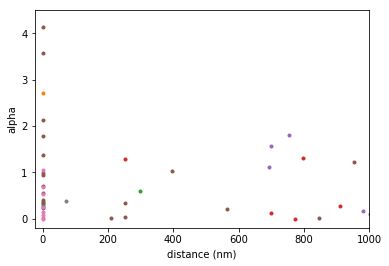

In [167]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(HBSS_1_df['Euc']*70, HBSS_1_df['alpha'], marker = '.')
ax1.scatter(HBSS_2_df['Euc']*70, HBSS_2_df['alpha'], marker = '.')
ax1.scatter(HBSS_3_df['Euc']*70, HBSS_3_df['alpha'], marker = '.')
ax1.scatter(HBSS_4_df['Euc']*70, HBSS_4_df['alpha'], marker = '.')
ax1.scatter(HBSS_5_df['Euc']*70, HBSS_5_df['alpha'], marker = '.')
ax1.scatter(SCM_1_df['Euc']*70, SCM_1_df['alpha'], marker = '.')
ax1.scatter(SCM_2_df['Euc']*70, SCM_2_df['alpha'], marker = '.')
ax1.scatter(SCM_3_df['Euc']*70, SCM_3_df['alpha'], marker = '.')
ax1.scatter(SCM_4_df['Euc']*70, SCM_4_df['alpha'], marker = '.')
ax1.scatter(SCM_5_df['Euc']*70, SCM_5_df['alpha'], marker = '.')
plt.ylim(-0.2,4.5)
plt.xlim(-25,1000)
plt.ylabel('alpha')
plt.xlabel('distance (nm)')
plt.show()

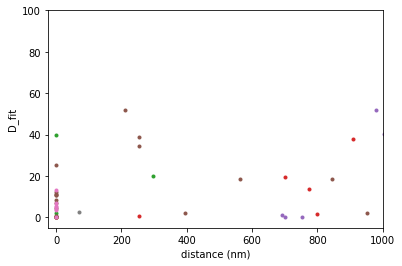

In [168]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(HBSS_1_df['Euc']*70, HBSS_1_df['D_fit'], marker = '.')
ax1.scatter(HBSS_2_df['Euc']*70, HBSS_2_df['D_fit'], marker = '.')
ax1.scatter(HBSS_3_df['Euc']*70, HBSS_3_df['D_fit'], marker = '.')
ax1.scatter(HBSS_4_df['Euc']*70, HBSS_4_df['D_fit'], marker = '.')
ax1.scatter(HBSS_5_df['Euc']*70, HBSS_5_df['D_fit'], marker = '.')
ax1.scatter(SCM_1_df['Euc']*70, SCM_1_df['D_fit'], marker = '.')
ax1.scatter(SCM_2_df['Euc']*70, SCM_2_df['D_fit'], marker = '.')
ax1.scatter(SCM_3_df['Euc']*70, SCM_3_df['D_fit'], marker = '.')
ax1.scatter(SCM_4_df['Euc']*70, SCM_4_df['D_fit'], marker = '.')
ax1.scatter(SCM_5_df['Euc']*70, SCM_5_df['D_fit'], marker = '.')
plt.ylim(-5,100)
plt.xlim(-25,1000)
plt.ylabel('D_fit')
plt.xlabel('distance (nm)')
plt.show()

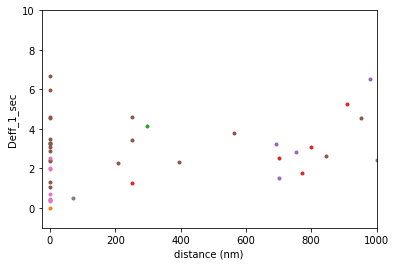

In [8]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(HBSS_1_df['Euc']*70, HBSS_1_df['Deff1'], marker = '.')
ax1.scatter(HBSS_2_df['Euc']*70, HBSS_2_df['Deff1'], marker = '.')
ax1.scatter(HBSS_3_df['Euc']*70, HBSS_3_df['Deff1'], marker = '.')
ax1.scatter(HBSS_4_df['Euc']*70, HBSS_4_df['Deff1'], marker = '.')
ax1.scatter(HBSS_5_df['Euc']*70, HBSS_5_df['Deff1'], marker = '.')
ax1.scatter(SCM_1_df['Euc']*70, SCM_1_df['Deff1'], marker = '.')
ax1.scatter(SCM_2_df['Euc']*70, SCM_2_df['Deff1'], marker = '.')
ax1.scatter(SCM_3_df['Euc']*70, SCM_3_df['Deff1'], marker = '.')
ax1.scatter(SCM_4_df['Euc']*70, SCM_4_df['Deff1'], marker = '.')
ax1.scatter(SCM_5_df['Euc']*70, SCM_5_df['Deff1'], marker = '.')
plt.ylim(-1,10)
plt.xlim(-25,1000)
plt.ylabel('Deff_1_sec')
plt.xlabel('distance (nm)')
plt.show()

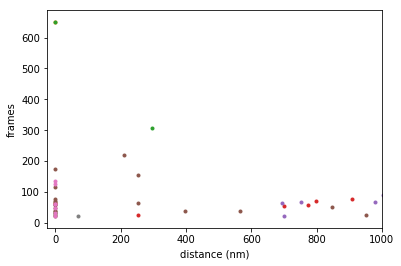

In [9]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(HBSS_1_df['Euc']*70, HBSS_1_df['frames'], marker = '.')
ax1.scatter(HBSS_2_df['Euc']*70, HBSS_2_df['frames'], marker = '.')
ax1.scatter(HBSS_3_df['Euc']*70, HBSS_3_df['frames'], marker = '.')
ax1.scatter(HBSS_4_df['Euc']*70, HBSS_4_df['frames'], marker = '.')
ax1.scatter(HBSS_5_df['Euc']*70, HBSS_5_df['frames'], marker = '.')
ax1.scatter(SCM_1_df['Euc']*70, SCM_1_df['frames'], marker = '.')
ax1.scatter(SCM_2_df['Euc']*70, SCM_2_df['frames'], marker = '.')
ax1.scatter(SCM_3_df['Euc']*70, SCM_3_df['frames'], marker = '.')
ax1.scatter(SCM_4_df['Euc']*70, SCM_4_df['frames'], marker = '.')
ax1.scatter(SCM_5_df['Euc']*70, SCM_5_df['frames'], marker = '.')
#plt.ylim(-1,10)
plt.xlim(-25,1000)
plt.ylabel('frames')
plt.xlabel('distance (nm)')
plt.show()

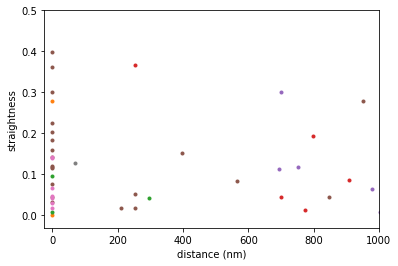

In [24]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(HBSS_1_df['Euc']*70, HBSS_1_df['straightness'], marker = '.')
ax1.scatter(HBSS_2_df['Euc']*70, HBSS_2_df['straightness'], marker = '.')
ax1.scatter(HBSS_3_df['Euc']*70, HBSS_3_df['straightness'], marker = '.')
ax1.scatter(HBSS_4_df['Euc']*70, HBSS_4_df['straightness'], marker = '.')
ax1.scatter(HBSS_5_df['Euc']*70, HBSS_5_df['straightness'], marker = '.')
ax1.scatter(SCM_1_df['Euc']*70, SCM_1_df['straightness'], marker = '.')
ax1.scatter(SCM_2_df['Euc']*70, SCM_2_df['straightness'], marker = '.')
ax1.scatter(SCM_3_df['Euc']*70, SCM_3_df['straightness'], marker = '.')
ax1.scatter(SCM_4_df['Euc']*70, SCM_4_df['straightness'], marker = '.')
ax1.scatter(SCM_5_df['Euc']*70, SCM_5_df['straightness'], marker = '.')
plt.ylim(-0.03,0.5)
plt.xlim(-25,1000)
plt.ylabel('straightness')
plt.xlabel('distance (nm)')
plt.show()

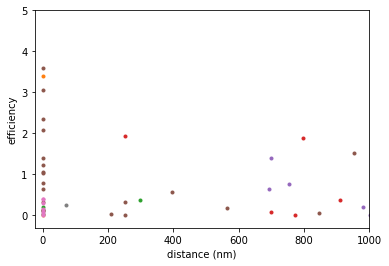

In [25]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(HBSS_1_df['Euc']*70, HBSS_1_df['efficiency'], marker = '.')
ax1.scatter(HBSS_2_df['Euc']*70, HBSS_2_df['efficiency'], marker = '.')
ax1.scatter(HBSS_3_df['Euc']*70, HBSS_3_df['efficiency'], marker = '.')
ax1.scatter(HBSS_4_df['Euc']*70, HBSS_4_df['efficiency'], marker = '.')
ax1.scatter(HBSS_5_df['Euc']*70, HBSS_5_df['efficiency'], marker = '.')
ax1.scatter(SCM_1_df['Euc']*70, SCM_1_df['efficiency'], marker = '.')
ax1.scatter(SCM_2_df['Euc']*70, SCM_2_df['efficiency'], marker = '.')
ax1.scatter(SCM_3_df['Euc']*70, SCM_3_df['efficiency'], marker = '.')
ax1.scatter(SCM_4_df['Euc']*70, SCM_4_df['efficiency'], marker = '.')
ax1.scatter(SCM_5_df['Euc']*70, SCM_5_df['efficiency'], marker = '.')
plt.ylim(-0.3,5)
plt.xlim(-25,1000)
plt.ylabel('efficiency')
plt.xlabel('distance (nm)')
plt.show()

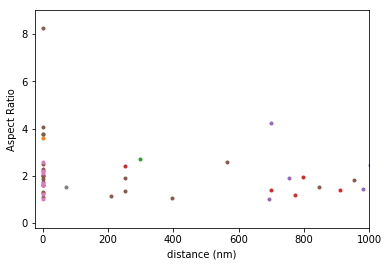

In [26]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(HBSS_1_df['Euc']*70, HBSS_1_df['AR'], marker = '.')
ax1.scatter(HBSS_2_df['Euc']*70, HBSS_2_df['AR'], marker = '.')
ax1.scatter(HBSS_3_df['Euc']*70, HBSS_3_df['AR'], marker = '.')
ax1.scatter(HBSS_4_df['Euc']*70, HBSS_4_df['AR'], marker = '.')
ax1.scatter(HBSS_5_df['Euc']*70, HBSS_5_df['AR'], marker = '.')
ax1.scatter(SCM_1_df['Euc']*70, SCM_1_df['AR'], marker = '.')
ax1.scatter(SCM_2_df['Euc']*70, SCM_2_df['AR'], marker = '.')
ax1.scatter(SCM_3_df['Euc']*70, SCM_3_df['AR'], marker = '.')
ax1.scatter(SCM_4_df['Euc']*70, SCM_4_df['AR'], marker = '.')
ax1.scatter(SCM_5_df['Euc']*70, SCM_5_df['AR'], marker = '.')
plt.ylim(-0.2,9)
plt.xlim(-25,1000)
plt.ylabel('Aspect Ratio')
plt.xlabel('distance (nm)')
plt.show()

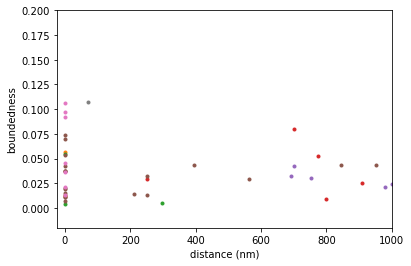

In [23]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(HBSS_1_df['Euc']*70, HBSS_1_df['boundedness'], marker = '.')
ax1.scatter(HBSS_2_df['Euc']*70, HBSS_2_df['boundedness'], marker = '.')
ax1.scatter(HBSS_3_df['Euc']*70, HBSS_3_df['boundedness'], marker = '.')
ax1.scatter(HBSS_4_df['Euc']*70, HBSS_4_df['boundedness'], marker = '.')
ax1.scatter(HBSS_5_df['Euc']*70, HBSS_5_df['boundedness'], marker = '.')
ax1.scatter(SCM_1_df['Euc']*70, SCM_1_df['boundedness'], marker = '.')
ax1.scatter(SCM_2_df['Euc']*70, SCM_2_df['boundedness'], marker = '.')
ax1.scatter(SCM_3_df['Euc']*70, SCM_3_df['boundedness'], marker = '.')
ax1.scatter(SCM_4_df['Euc']*70, SCM_4_df['boundedness'], marker = '.')
ax1.scatter(SCM_5_df['Euc']*70, SCM_5_df['boundedness'], marker = '.')
plt.ylim(-0.02,0.2)
plt.xlim(-25,1000)
plt.ylabel('boundedness')
plt.xlabel('distance (nm)')
plt.show()

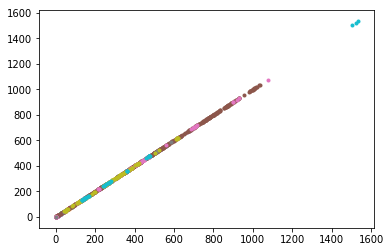

In [6]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(HBSS_1_df['Euc'], HBSS_1_df['Euc'], marker = '.')
ax1.scatter(HBSS_2_df['Euc'], HBSS_2_df['Euc'], marker = '.')
ax1.scatter(HBSS_3_df['Euc'], HBSS_3_df['Euc'], marker = '.')
ax1.scatter(HBSS_4_df['Euc'], HBSS_4_df['Euc'], marker = '.')
ax1.scatter(HBSS_5_df['Euc'], HBSS_5_df['Euc'], marker = '.')
ax1.scatter(SCM_1_df['Euc'], SCM_1_df['Euc'], marker = '.')
ax1.scatter(SCM_2_df['Euc'], SCM_2_df['Euc'], marker = '.')
ax1.scatter(SCM_3_df['Euc'], SCM_3_df['Euc'], marker = '.')
ax1.scatter(SCM_4_df['Euc'], SCM_4_df['Euc'], marker = '.')
ax1.scatter(SCM_5_df['Euc'], SCM_5_df['Euc'], marker = '.')
#plt.ylim(0,4.5)
#plt.xlim(0,1000)
plt.show()

In [7]:
x = np.zeros(tot_traj+1)
y = np.zeros(tot_traj+1)

p = 0
for i in range(np.size(plot_array)):
    for j in range(len(plot_array[i])):
        x[p] = i+1
        y[p] = plot_array[i][j]
        p = p + 1

plt.subplot(211)
plt.boxplot(summary_array, sym = '')
plt.subplot(212)
plt.boxplot(plot_array, showfliers = False)
plt.plot(x,y,'k.')
plt.show()

NameError: name 'tot_traj' is not defined